In [1]:
import pickle
import numpy as np
from scipy.stats import ttest_ind
# import pandas
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

In [2]:
instance_correct = pickle.load(open("results/syntax_attribution_instance_correct6.pkl", "rb"))
instance_mispredict = pickle.load(open("results/syntax_attribution_instances_misprediction6.pkl", "rb"))
len(instance_correct), len(instance_mispredict)

(27825, 7118)

In [3]:
syntax_type_list = list(instance_correct[0].keys())

In [4]:
syntax_type_list

['annotation',
 'basictype',
 'boolean',
 'decimalinteger',
 'identifier',
 'keyword',
 'modifier',
 'operator',
 'separator',
 'null',
 'string',
 'decimalfloatingpoint']

In [6]:
from sklearn.model_selection import train_test_split

len_correct = len(instance_correct)

instance_correct_IDF, instance_correct_Diagnose = train_test_split(instance_correct, test_size=0.3, random_state=42)

instance_mispredict_IDF, instance_mispredict_Diagnose = train_test_split(instance_mispredict, test_size=0.3, random_state=42)

len(instance_correct_IDF), len(instance_correct_Diagnose), len(instance_mispredict_IDF), len(instance_mispredict_Diagnose)

(19477, 8348, 4982, 2136)

In [7]:
def get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type):
    corerct_temp_list = []
    mispredict_temp_list = []

    for i in range(len(instance_correct_IDF)):
        temp = np.array(instance_correct_IDF[i][syntax_type])
        if temp.shape[0] == 1:
            corerct_temp_list.append(np.squeeze(temp, axis =0))
            
    for i in range(len(instance_mispredict_IDF)):
        temp = np.array(instance_mispredict_IDF[i][syntax_type])
        if temp.shape[0] == 1:
            mispredict_temp_list.append(np.squeeze(temp, axis =0))
            
    return corerct_temp_list, mispredict_temp_list

In [8]:
def get_syntax_head_level_attribution_ttest_result(instance_correct, instance_mispredict):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

    p_value_distribution = []
    significant_head_number = 0

    for layer in range(coverted_top_mispredict_annotation.shape[0]):
        layer_attronutions = []
        for head in range(coverted_top_mispredict_annotation.shape[1]):
            # get 95% confidence interval
            temp_data = coverted_top_correct_annotation[layer][head]
            correct_data_mean = np.mean(temp_data)
            correct_data_std = np.std(temp_data)
            correct_lower = correct_data_mean - 1.96 * correct_data_std
            correct_upper = correct_data_mean + 1.96 * correct_data_std
            # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data)) 
            temp_data_2 = coverted_top_mispredict_annotation[layer][head]
            mispredict_data_mean = np.mean(temp_data_2)
            mispredict_data_std = np.std(temp_data_2)
            mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
            mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
            # mispred_lower, mispred_upper = st.t.interval(alpha=0.95, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
            
            # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
            # get data between the lower and upper bound
            P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
            P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispredict_lower and x <= mispredict_upper]
            
            p_value = ttest_ind(P95_correct_data, P95_mispred_data).pvalue
            if p_value < 0.05:
                layer_attronutions.append(0.05)
                significant_head_number += 1
            else:
                layer_attronutions.append(1)
        p_value_distribution.append(layer_attronutions)
        
    return p_value_distribution, significant_head_number

In [9]:
p_value_dict = {}
significant_head_number_dict = {}

for syntax_type in syntax_type_list:
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
    p_value_dict[syntax_type], significant_head_number_dict[syntax_type]= get_syntax_head_level_attribution_ttest_result(corerct_temp_list, mispredict_temp_list)


In [10]:
print(len(p_value_dict.keys()))
p_value_dict.keys()

12


dict_keys(['annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])

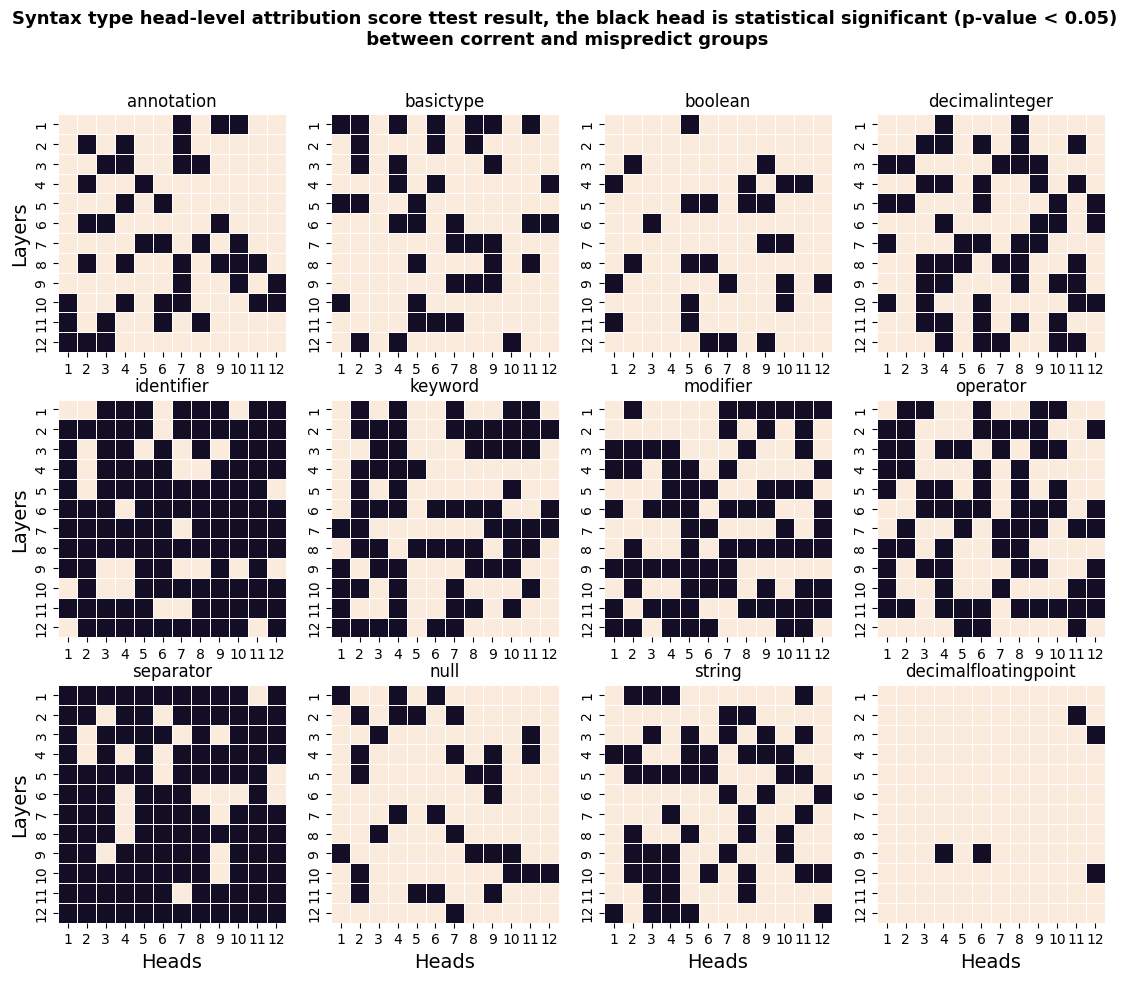

In [13]:
fig, axs = plt.subplots(3, 4)
# set title for whole figure
fig.suptitle('Syntax type head-level attribution score ttest result, the black head is statistical significant (p-value < 0.05)\n between corrent and mispredict groups', fontsize=13, fontweight='bold')

for i in range(3):
    for j in range(4):
        syntax_type = syntax_type_list[i*4+j]
        p_value_distribution = p_value_dict[syntax_type]
        p_value_distribution = np.array(p_value_distribution)
        p_value_distribution = np.transpose(p_value_distribution, (1, 0))
        # axs[i, j].imshow(p_value_distribution, cmap='hot', interpolation='nearest')
        axs[i, j] = sns.heatmap(p_value_distribution, cbar=False, linewidth=0.5, ax=axs[i, j], vmin=0, vmax=1)
        axs[i, j].set_title(syntax_type)
        # add 1 to xticks and yticks
        axs[i, j].set_xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
        axs[i, j].set_yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

# set xlabel for bottom row of subplots
numb = 0
for ax in axs.flat:
    # 
    numb += 1
    if numb > 8:
        ax.set(xlabel='Heads')
        ax.xaxis.label.set_size(14)
# set ylabel for left column of subplots
    if numb == 1 or numb == 5 or numb == 9:
        ax.set(ylabel='Layers')
        ax.yaxis.label.set_size(14)

# change figure size
fig.set_size_inches(13.5, 10.5)
plt.show()

In [14]:
significant_head_record = [[[] for col in range(12)] for row in range(12)]

for syntax_type in list(instance_correct[0].keys()):
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)

In [25]:
interesting_syntax_type = ['identifier', 'keyword', 'modifier', 'operator', 'separator', 'string']
# interesting_syntax_type = syntax_type_list

In [26]:
def calculate_significant_head_number(p_value_distribution):
    significant_head_record = [[[] for col in range(12)] for row in range(12)]
    for syntax in interesting_syntax_type:
        for layer in range(len(p_value_distribution[syntax])):
            for head in range(len(p_value_distribution[syntax][layer])):
                if p_value_distribution[syntax][layer][head] == 0.05:
                    significant_head_record[layer][head].append(syntax)
                    
    return significant_head_record

In [27]:
significant_head_record = calculate_significant_head_number(p_value_dict)

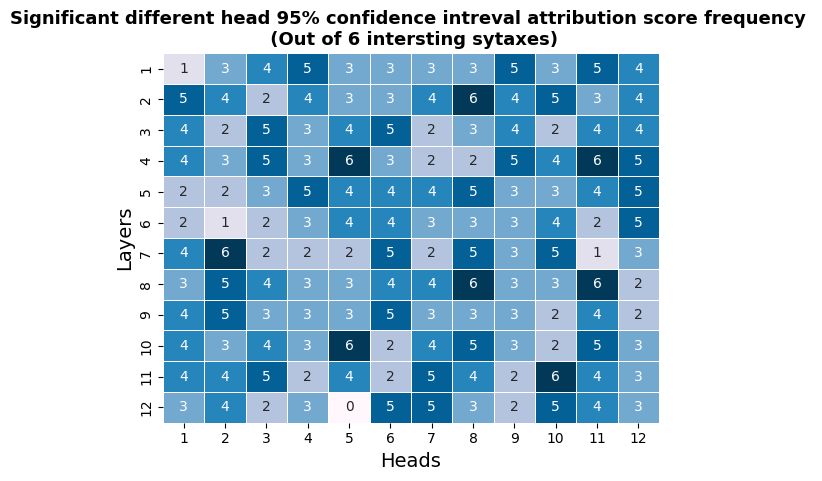

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
head_significant_frequency = [[0 for col in range(12)] for row in range(12)]

for layer in range(len(significant_head_record)):
    for head in range(len(significant_head_record[layer])):
        head_significant_frequency[layer][head] = len(significant_head_record[layer][head])

ax = sns.heatmap(head_significant_frequency, linewidth=0.5, annot=True, cbar=False, fmt='d', cmap='PuBu', vmin=0, vmax=len(interesting_syntax_type))
plt.title('Significant different head 95% confidence intreval attribution score frequency \n (Out of {} intersting sytaxes)'.format(len(interesting_syntax_type)), fontsize=13, fontweight='bold')
# add one to the x axis
plt.xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
# do same thing for y axis
plt.yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

plt.xlabel('Heads', fontsize=14)
plt.ylabel('Layers', fontsize=14)
plt.show()

In [50]:
most_significant_head = []
for layer in range(len(head_significant_frequency)):
    for head in range(len(head_significant_frequency[layer])):
        if head_significant_frequency[layer][head] >= 6:
            most_significant_head.append((layer, head))
print('Number of most significant heads:', len(most_significant_head))
print("(layer, head))")
print(most_significant_head)

Number of most significant heads: 8
(layer, head))
[(1, 7), (3, 4), (3, 10), (6, 1), (7, 7), (7, 10), (9, 4), (10, 9)]


In [51]:
def get_syntax_significant_head_distributions(instance_correct, instance_mispredict, most_significant_head):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))
    
    correct_heads_attention = []
    mispred_heads_attention = []
    
    
    for layer, head in most_significant_head:
        # get 95% confidence interval
        temp_data = coverted_top_correct_annotation[layer][head]
        correct_data_mean = np.mean(temp_data)
        correct_data_std = np.std(temp_data)
        correct_lower = correct_data_mean - 1.96 * correct_data_std
        correct_upper = correct_data_mean + 1.96 * correct_data_std
        # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data)) 
        # correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head])
        temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        mispredict_data_mean = np.mean(temp_data_2)
        mispredict_data_std = np.std(temp_data_2)
        mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
        mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
        # mispred_lower, mispred_upper = st.t.interval(alpha=0.95, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
        # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
        
        # get data between the lower and upper bound
        P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
        P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispredict_lower and x <= mispredict_upper]

        correct_heads_attention.append(P95_correct_data)
        mispred_heads_attention.append(P95_mispred_data)
        
    return correct_heads_attention, mispred_heads_attention

In [52]:
# Plot the boxplot of the most significant head attention weight distribution
corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
correct_heads_attention, mispred_heads_attention = get_syntax_significant_head_distributions(corerct_temp_list,
                                                                                             mispredict_temp_list,
                                                                                             most_significant_head)

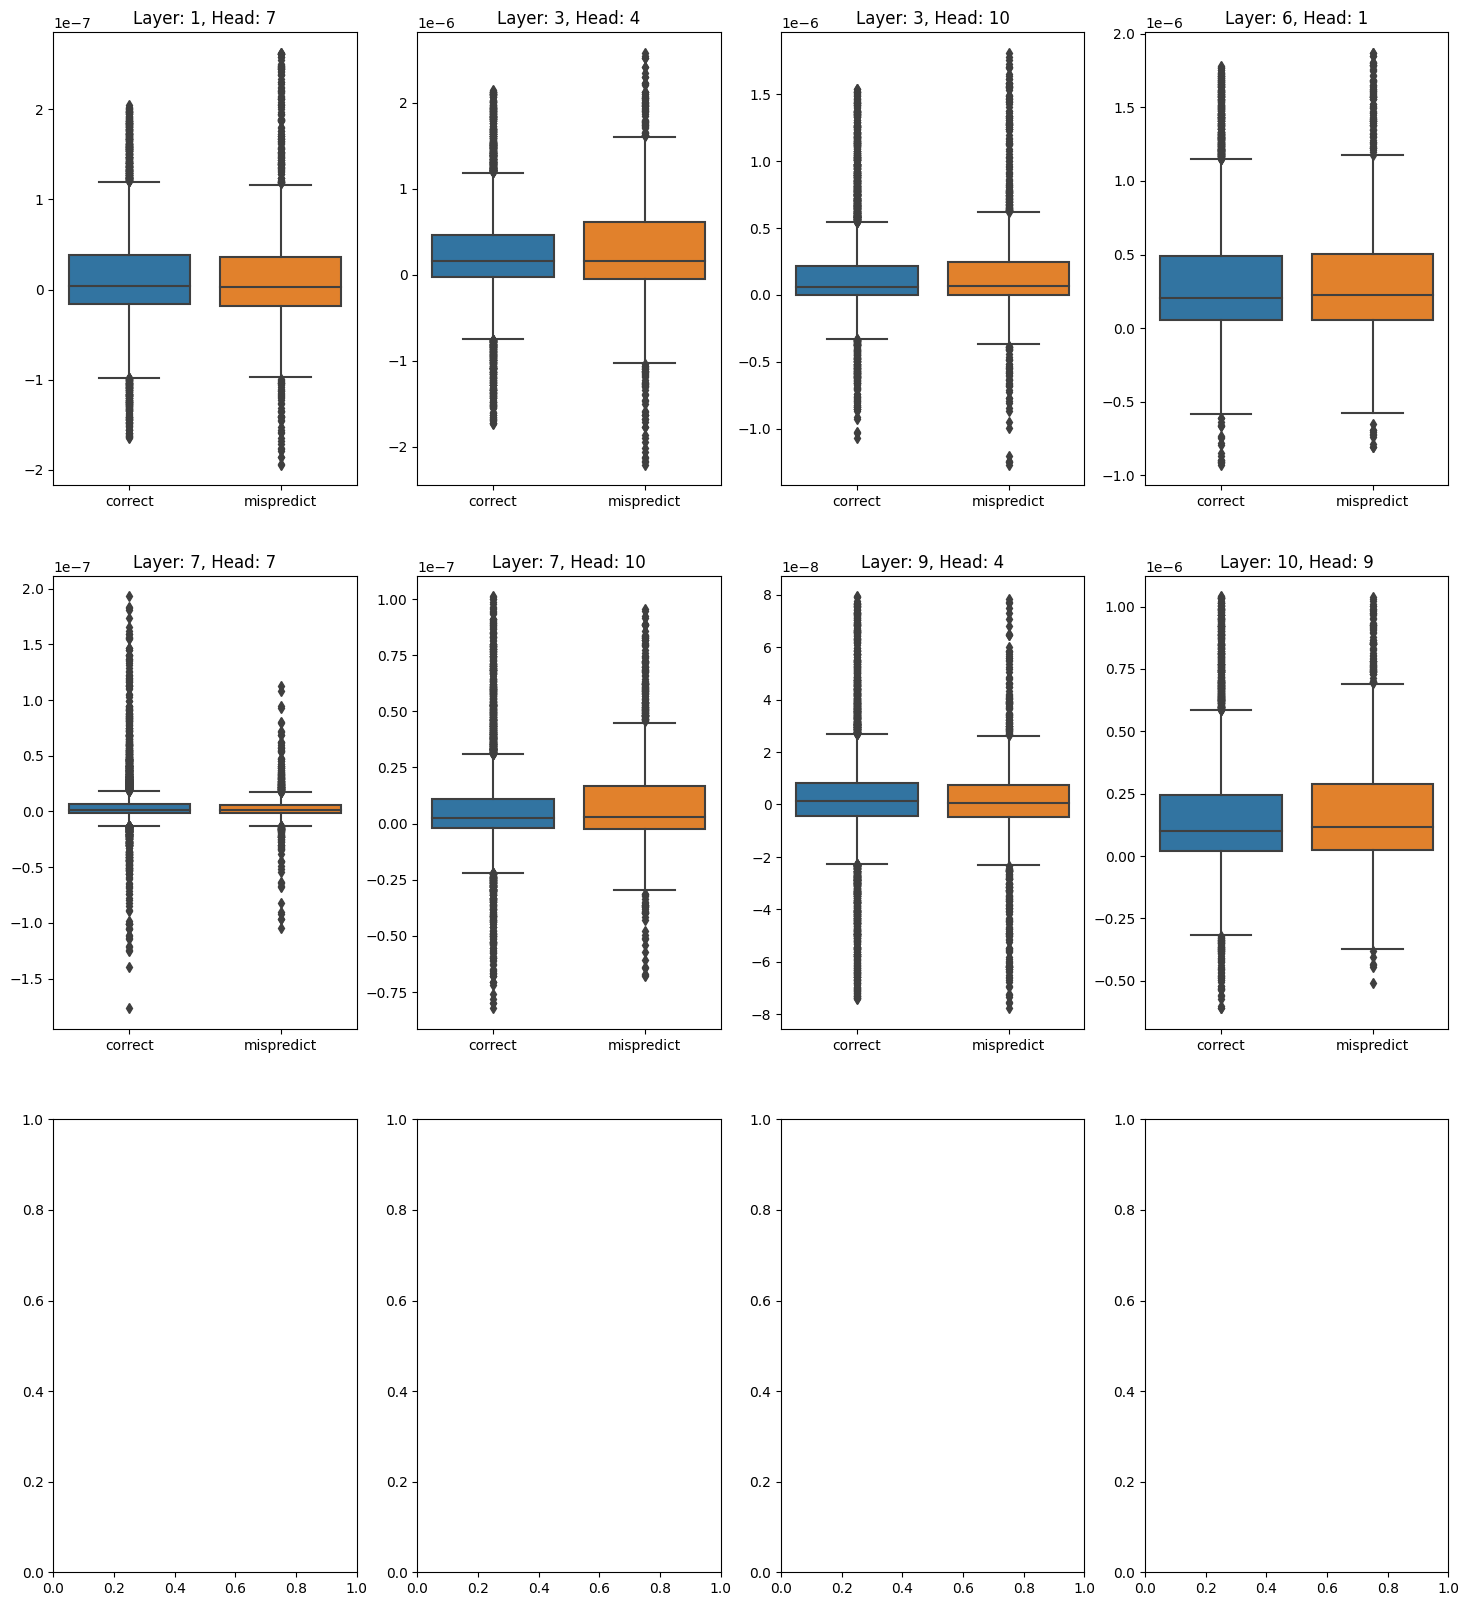

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot all most significant head attention weight distribution
# each row plot 4 paris 
syntax_type = "string"

corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
correct_heads_attention, mispred_heads_attention = get_syntax_significant_head_distributions(corerct_temp_list,
                                                                                             mispredict_temp_list,
                                                                                             most_significant_head)


fig, axs = plt.subplots(len(correct_heads_attention)//4 + 1, 4, figsize=(18, 20))
# fig.suptitle('Significant head attribution comparison result', fontsize=13, fontweight='bold')

for i in range(len(correct_heads_attention)):
    a = correct_heads_attention[i]
    b = mispred_heads_attention[i]
    dict = {'prediction': ['correct']*len(a) + ['mispredict']*len(b), 'attention_weight': a + b}
    df = pd.DataFrame(dict)
    sns.boxplot(x="prediction", y="attention_weight", data=df, ax=axs[i//4][i%4])
    axs[i//4][i%4].set_title('Layer: {}, Head: {}'.format(most_significant_head[i][0], most_significant_head[i][1]))
    # remove x label for all but the last row
    axs[i//4][i%4].set_xlabel('')
    # remove y label for all but the first column
    axs[i//4][i%4].set_ylabel('')
    # remove x ticks for all but the last row
    # axs[i//4][i%4].set_xticks([])

In [32]:
def get_syntax_significant_head_upper_lower_bound(instance_correct, instance_mispredict, most_significant_head):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))
    
    correct_heads_attention = []
    mispred_heads_attention = []
    
    upper_lower_bounds = {}
    
    
    for layer, head in most_significant_head:
        # get 95% confidence interval
        temp_data = coverted_top_correct_annotation[layer][head]
        correct_data_mean = np.mean(temp_data)
        correct_data_std = np.std(temp_data)
        correct_lower = correct_data_mean - 1.96 * correct_data_std
        correct_upper = correct_data_mean + 1.96 * correct_data_std
        # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data))
        within_list = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
        # print("Covered percentage: ", len(within_list)/len(coverted_top_correct_annotation[layer][head]))
        # correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head], confidence=0.98)
        temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        # temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        mispredict_data_mean = np.mean(temp_data_2)
        mispredict_data_std = np.std(temp_data_2)
        mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
        mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
        # mispred_lower, mispred_upper = st.t.interval(alpha=0.8, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
        # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head], confidence=0.95)
        
        upper_lower_bounds[(layer, head)] = (correct_lower, correct_upper, mispredict_lower, mispredict_upper)
    return upper_lower_bounds

In [33]:
# get upper and lower bound of the attention weight for each head in each layer for each syntax type 
check_book = {} 

for syntax_type in list(instance_correct[0].keys()):
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
    upper_lower_bounds = get_syntax_significant_head_upper_lower_bound(corerct_temp_list,
                                                                        mispredict_temp_list,
                                                                        most_significant_head)
    check_book[syntax_type] = upper_lower_bounds

In [34]:
len(instance_correct_Diagnose), len(instance_mispredict_Diagnose)

(8348, 2136)

In [35]:
def check_head_values(instance, check_book, most_significant_head):
    available_syntax = []
    for syntax_type in list(instance.keys()):
        if np.array(instance[syntax_type]).shape[0] == 1:
            available_syntax.append(syntax_type)
    
    within_bound_check = 0
    Outof_bound_check = 0
    
    for layer, head in most_significant_head:
        for syntax_type in available_syntax:
            attention_weights = np.array(instance[syntax_type]).squeeze(axis=0)
            max_attention = np.max(attention_weights, axis=2)
            
            if max_attention[layer][head] >= check_book[syntax_type][(layer, head)][0] and max_attention[layer][head] <= check_book[syntax_type][(layer, head)][1]:
                within_bound_check += 1
            else:
                Outof_bound_check += 1
        
    return within_bound_check, Outof_bound_check

In [36]:
within = []
out = []

for i in range(len(instance_correct_Diagnose)):
    within_bound_check, Outof_bound_check = check_head_values(instance_correct_Diagnose[i], check_book, most_significant_head)
    within.append(within_bound_check)
    out.append(Outof_bound_check)
    
for i in range(len(instance_mispredict_Diagnose)):
    within_bound_check, Outof_bound_check = check_head_values(instance_mispredict_Diagnose[i], check_book, most_significant_head)
    within.append(within_bound_check)
    out.append(Outof_bound_check)
    
dict = {"Within_count": within, "Out_count": out, "True_value": [1]*len(instance_correct_Diagnose) + [0]*len(instance_mispredict_Diagnose)}

result_df = pd.DataFrame(dict)

In [48]:
result_df['total'] = result_df['Within_count'] + result_df['Out_count']
result_df['Within_percentage'] = result_df['Within_count']/result_df['total']

result_df['diagnose'] = result_df['Within_percentage'] > 0.95
result_df['diagnose'] = result_df['diagnose'].astype(int)

In [38]:
result_df.head()

,Within_count,Out_count,True_value,total,Within_percentage,diagnose
0,108,0,1,108,1.000000,1
1,0,0,1,0,NaN,0
2,161,1,1,162,0.993827,1
3,126,0,1,126,1.000000,1
4,89,1,1,90,0.988889,1


In [49]:
print(classification_report(result_df['True_value'], result_df['diagnose']))

              precision    recall  f1-score   support

           0       0.21      0.27      0.24      2136
           1       0.80      0.74      0.77      8348

    accuracy                           0.65     10484
   macro avg       0.51      0.51      0.51     10484
weighted avg       0.68      0.65      0.66     10484

